In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import shap
import pickle

from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'


In [3]:
dataset = SubjectDataset(data_path, selected_labels, data_string='scores')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [4]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

scores = np.array([dataset[index]['scores'] for index in range(len(dataset.subject_list))])

In [5]:
scoring = 'roc_auc'

with parallel_backend('threading', n_jobs=8):

    model = HistGradientBoostingClassifier(learning_rate=0.0001, max_iter=4, max_leaf_nodes=4, l2_regularization=4.0, min_samples_leaf=150, max_depth=2, class_weight='balanced', scoring=scoring)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, scores, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

Cross-validation roc_auc scores: [0.71 0.73 0.82 0.72 0.74 0.74 0.76 0.83 0.69 0.81]
Mean cross-validation roc_auc: 0.7558536045997346
Standard deviation of cross-validation roc_auc: 0.045842915098910544


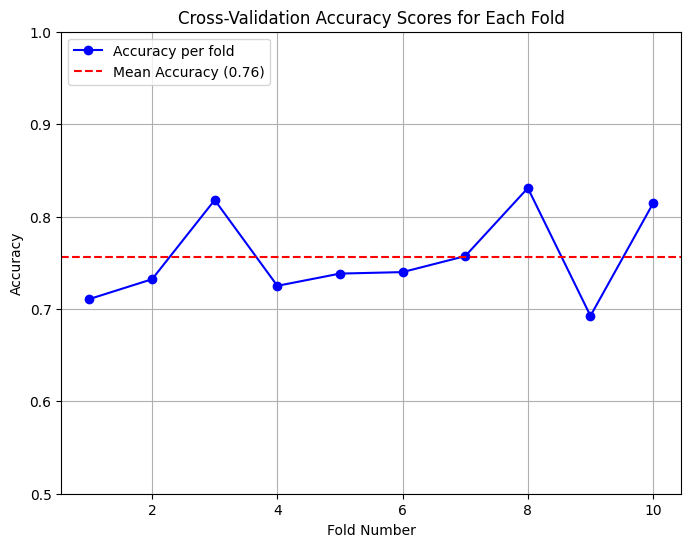

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label=f'{scoring} per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean {scoring} ({np.mean(cv_scores):.2f})')
plt.title(f'Cross-Validation {scoring} Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel(f'{scoring}')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Cross-validation roc_auc scores: [0.84 0.86 0.86 0.82 0.87 0.87 0.88 0.86 0.85 0.83]
Mean cross-validation roc_auc: 0.8539591994692615
Standard deviation of cross-validation roc_auc: 0.01921576915448552


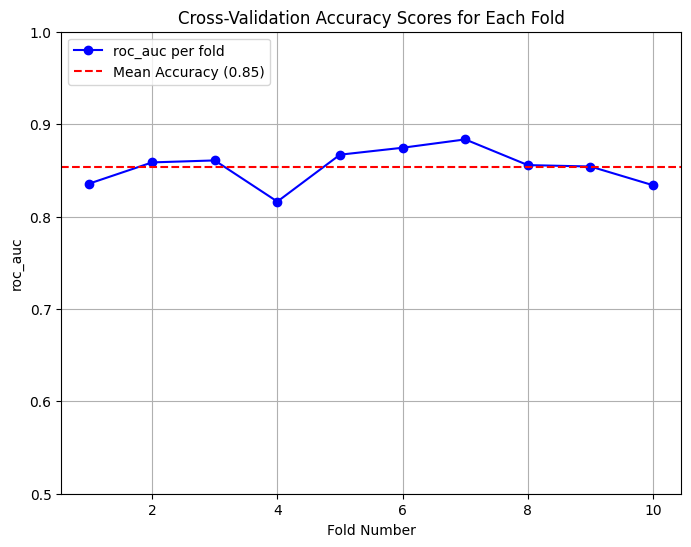

In [76]:
scoring = 'roc_auc'

with parallel_backend('threading', n_jobs=8):

    model = RandomForestClassifier(n_estimators=200, max_depth=2,  max_features='sqrt', class_weight='balanced', bootstrap=True, oob_score=True)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, scores, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label=f'{scoring} per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel(f'{scoring}')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [77]:
model = RandomForestClassifier(n_estimators=200, max_depth=2,  max_features='sqrt', class_weight='balanced', bootstrap=True, oob_score=True)

model.fit(scores, labels)

with open(f'scores_gbdt.pkl', 'wb') as file:
    
    pickle.dump(model, file)  
